# Digit Recognizer

Learn computer vision fundamentals with the famous MNIST data

https://www.kaggle.com/competitions/digit-recognizer/data

Kaggle Profile: https://www.kaggle.com/remyflatt

Achives:
* Classification model: 96% accuracy
* Conv2d model: 99% accuracy

## Helper functions

In [1]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [2]:
def make_predictions(model, dataset):
  """
  Return an array of predictions for each item in the dataset
  """
  return model.predict(dataset).argmax(axis=1)

In [3]:
def create_kaggle_submission(model, preds):
  """
  Write to CSV the preds in the format for the Kaggle Submission.
  """
  arr = np.arange(1, len(preds) +1)
  data = {'ImageId': arr, 'Label': preds }

  path = "/content/drive/MyDrive/Kaggle/digit-recognizer/" + model.name + "-submission.csv"

  pd.DataFrame(data, columns=["ImageId", "Label"]).to_csv(path, index=False)

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def confusion_and_classification(model, labels, dataset):
  """
  Make prediction against the dataset using the model and print out a 
  confusion matrix and a classification report. 
  """
  probs = model.predict(dataset)
  preds = probs.argmax(axis=1)  

  print(f"Confusion Matrix:\n")
  print(confusion_matrix(y_true=labels, y_pred=preds))

  print(f"\nClassification Report:\n")
  print(classification_report(labels, preds))

In [5]:
def save_model_to_drive(model):
  path = "/content/drive/MyDrive/Kaggle/digit-recognizer/" + model.name
  classification_model.save(path)

## Import libraries

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

NUM_CLASSES = 10

## Load the training and test data

In [7]:
DIR_PATH   = "/content/drive/MyDrive/Kaggle/digit-recognizer"
TRAIN_PATH = DIR_PATH + "/" + "train.csv"
TEST_PATH  = DIR_PATH + "/" + "test.csv"

In [8]:
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

## Inspect the data

In [9]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

print(f"Train dim: {train_df.ndim}")
print(f"Test dim: {test_df.ndim}")

print(f"Train has nulls: {train_df.isnull().values.any()}")
print(f"Test has nulls: {test_df.isnull().values.any()}")

Train Shape: (42000, 785)
Test Shape: (28000, 784)
Train dim: 2
Test dim: 2
Train has nulls: False
Test has nulls: False


In [12]:
# Check Datatypes
train_df.dtypes
test_df.dtypes

pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 784, dtype: object

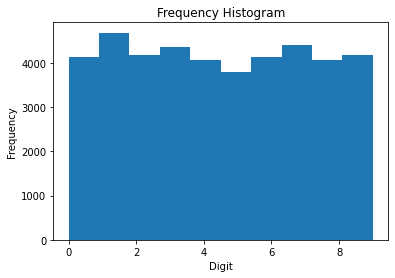

In [13]:
# Plot distribution 
plt.hist(train_df['label'])
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel="Digit");

## Create features and labels

In [14]:
train_labels = train_df["label"]
train_labels.head()

train_df = train_df.drop(columns=['label']).astype('float32')
len(train_labels), len(train_df)

(42000, 42000)

In [15]:
# Convert from int to float
train_df.astype('float32')
train_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create validation data

In [16]:
train_data, val_data, train_labels, val_labels = train_test_split(train_df,
                                                                  train_labels,
                                                                  test_size=0.2, # use 20% of training data as validation data
                                                                  random_state=42) 

In [17]:
len(train_data), len(val_data), len(train_labels), len(val_labels)

(33600, 8400, 33600, 8400)

In [18]:
print(train_data.shape, val_data.shape, train_labels.shape, val_labels.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


## Convert to Data Pipeline

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset   = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_df).batch(32).prefetch(tf.data.AUTOTUNE)

## Create Model Callbacks

In [20]:
def create_checkpoint_callback(filepath, save_weights_only=True, save_best_only=True):
  return tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                            save_weights_only=save_weights_only,
                                            save_best_only=save_best_only,
                                            monitor="val_accuracy",
                                            verbose=1)

def create_early_stopping_callback(patience=3):
  return tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                         patience=patience,
                                         verbose=1)
  
def create_reduce_lr_callback():
  return tf.keras.callbacks.ReduceLROnPlateau(verbose=1)


## Classification Model

### Create and train a classification model

In [21]:
classification_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1/255.0),

  tf.keras.layers.Dense(100, activation="relu", input_shape=(784,)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
], name="classification_model")

classification_model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)

classification_history = classification_model.fit(
  train_dataset,
  epochs=50,
  validation_data=val_dataset,
  validation_steps=len(val_dataset),
  callbacks=[
    create_checkpoint_callback(classification_model.name), 
    create_early_stopping_callback(), 
    create_reduce_lr_callback()
  ]
)

Epoch 1/50
1037/1050 [============================>.] - ETA: 0s - loss: 0.5465 - accuracy: 0.8317
Epoch 1: val_accuracy improved from -inf to 0.92583, saving model to classification_model
1050/1050 [==============================] - 13s 4ms/step - loss: 0.5420 - accuracy: 0.8331 - val_loss: 0.2435 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 2/50
1046/1050 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9349
Epoch 2: val_accuracy improved from 0.92583 to 0.94369, saving model to classification_model
1050/1050 [==============================] - 4s 3ms/step - loss: 0.2196 - accuracy: 0.9349 - val_loss: 0.1788 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 3/50
1040/1050 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9483
Epoch 3: val_accuracy improved from 0.94369 to 0.95869, saving model to classification_model
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1684 - accuracy: 0.9485 - val_loss: 0.1432 - val_accuracy: 0.9587 - lr

In [22]:
classification_model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 79,620
Trainable params: 79,620
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Clone and create model with the best weights
classification_model.load_weights(classification_model.name)

classification_model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)


In [24]:
loss, accuracy = classification_model.evaluate(val_dataset)
print(f"Model loss on the validation set: {loss:.2f}")
print(f"Model accuracy on the validation set: {100*accuracy:.2f}%")

263/263 [==============================] - 1s 2ms/step - loss: 0.1085 - accuracy: 0.9696
Model loss on the validation set: 0.11
Model accuracy on the validation set: 96.96%


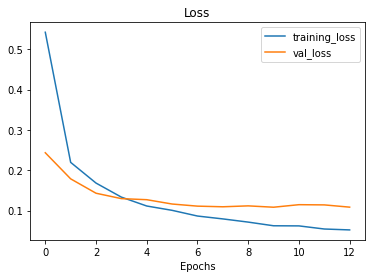

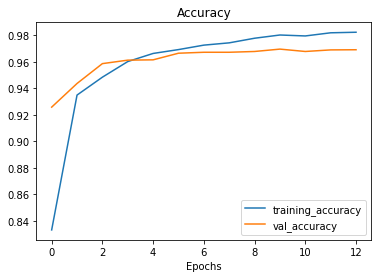

In [25]:
plot_loss_curves(classification_history)

### Make and evaluate predictions on val dataset

In [26]:
confusion_and_classification(classification_model, val_labels, val_dataset)

263/263 [==============================] - 0s 1ms/step
Confusion Matrix:

[[807   0   0   2   1   1   4   1   0   0]
 [  0 900   2   0   1   0   0   2   3   1]
 [  3   8 813   2   7   0   1   9   3   0]
 [  1   2   4 908   0   5   0   6   8   3]
 [  3   0   1   0 815   0   5   2   0  13]
 [  2   1   0  15   2 661  13   1   4   3]
 [  5   1   2   0   1   2 773   0   1   0]
 [  0   4   3   1   4   1   0 875   1   4]
 [  1   6   7   2   4   5   5   3 801   1]
 [  2   2   1  11  11   0   0  16   3 792]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       816
           1       0.97      0.99      0.98       909
           2       0.98      0.96      0.97       846
           3       0.96      0.97      0.97       937
           4       0.96      0.97      0.97       839
           5       0.98      0.94      0.96       702
           6       0.97      0.98      0.97       785
           7       0.96      0.98    

### Save model

In [27]:
save_model_to_drive(classification_model)

### Make predictions on test data and create submission

In [28]:
classification_preds = make_predictions(classification_model, test_dataset)
create_kaggle_submission(classification_model, classification_preds)

875/875 [==============================] - 2s 2ms/step


## Conv2D Model

In [29]:
conv2d_model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1/255.0),

  tf.keras.layers.Reshape(input_shape=(784,), target_shape=(28, 28, 1)),

  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.MaxPool2D(2),

  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.MaxPool2D(2),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
], name="conv2d_model")

conv2d_model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)

conv2d_history = conv2d_model.fit(
  train_dataset,
  epochs=50,
  validation_data=val_dataset,
  validation_steps=len(val_dataset),
  callbacks=[
    create_checkpoint_callback(conv2d_model.name), 
    create_early_stopping_callback(), 
    create_reduce_lr_callback()
  ]
)

Epoch 1/50
1046/1050 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9307
Epoch 1: val_accuracy improved from -inf to 0.97262, saving model to conv2d_model
1050/1050 [==============================] - 13s 6ms/step - loss: 0.2237 - accuracy: 0.9310 - val_loss: 0.0901 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 2/50
1044/1050 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9793
Epoch 2: val_accuracy improved from 0.97262 to 0.98083, saving model to conv2d_model
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0690 - accuracy: 0.9794 - val_loss: 0.0621 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 3/50
1047/1050 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9850
Epoch 3: val_accuracy improved from 0.98083 to 0.98464, saving model to conv2d_model
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0483 - accuracy: 0.9850 - val_loss: 0.0497 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 4/50
1049

In [30]:
conv2d_model.summary()


Model: "conv2d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 784)               0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                      

In [31]:
# Reload model with the best weights
conv2d_model.load_weights(conv2d_model.name)

conv2d_model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)


In [32]:
loss, accuracy = conv2d_model.evaluate(val_dataset)
print(f"Model loss on the validation set: {loss:.2f}")
print(f"Model accuracy on the validation set: {100*accuracy:.2f}%")

263/263 [==============================] - 1s 3ms/step - loss: 0.0288 - accuracy: 0.9913
Model loss on the validation set: 0.03
Model accuracy on the validation set: 99.13%


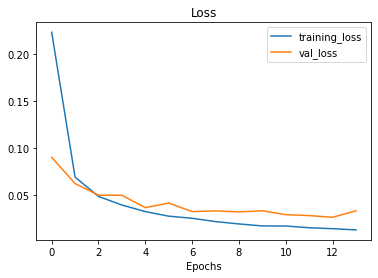

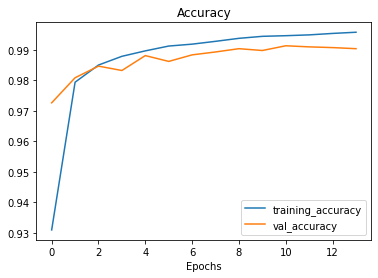

In [33]:
plot_loss_curves(conv2d_history)

### Make and evaluate predictions on val dataset

In [34]:
confusion_and_classification(conv2d_model, val_labels, val_dataset)

263/263 [==============================] - 1s 2ms/step
Confusion Matrix:

[[810   0   0   0   0   0   4   0   1   1]
 [  0 906   2   0   0   0   0   1   0   0]
 [  1   0 840   1   1   0   2   0   1   0]
 [  0   0   1 926   0   6   0   1   3   0]
 [  0   2   0   0 823   0   3   1   1   9]
 [  0   1   0   2   0 693   4   0   2   0]
 [  0   0   0   0   0   1 784   0   0   0]
 [  0   3   6   0   1   0   0 882   0   1]
 [  0   0   2   0   0   0   0   0 831   2]
 [  0   1   0   1   0   3   0   0   1 832]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       816
           1       0.99      1.00      0.99       909
           2       0.99      0.99      0.99       846
           3       1.00      0.99      0.99       937
           4       1.00      0.98      0.99       839
           5       0.99      0.99      0.99       702
           6       0.98      1.00      0.99       785
           7       1.00      0.99    

### Save Model

In [35]:
save_model_to_drive(conv2d_model)

### Make predictions on test dataset and create submission


In [36]:
conv2d_preds = make_predictions(conv2d_model, test_dataset)
create_kaggle_submission(conv2d_model, conv2d_preds)

875/875 [==============================] - 2s 3ms/step
